In [1]:
!pip install numpy pandas tensorflow scikit-learn

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2db

### Load IMDb dataset and split into train test

In [75]:
import pandas as pd

df = pd.read_csv('IMDB_Movies.csv')

In [76]:
df.head()

,review,sentiment
0,The best thing -- and that's pretty good -- ab...,1
1,"In the early '80s, I recorded Honky Tonk Freew...",1
2,"Billy Crystal is Larry, a writer who hasn't wr...",1
3,I would give this movie a good strong 7. While...,1
4,I use IMDB very much. Mainly reading comments ...,1


In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=12)

In [23]:
# import matplotlib.pyplot as plt

# # Count the occurrences of each class in the training and test sets
# train_class_counts = y_train.value_counts()
# test_class_counts = y_test.value_counts()

# # Create subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# # Plot for training set
# axs[0].bar(train_class_counts.index, train_class_counts.values, color='blue')
# axs[0].set_title('Training Set')
# axs[0].set_xlabel('Sentiment')
# axs[0].set_ylabel('Count')

# # Plot for test set
# axs[1].bar(test_class_counts.index, test_class_counts.values, color='green')
# axs[1].set_title('Test Set')
# axs[1].set_xlabel('Sentiment')
# axs[1].set_ylabel('Count')

# plt.tight_layout()
# plt.show()


### Create Bag-of-Words (BoW) Feature Vectors

In [83]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Convert Data to PyTorch Tensors

In [84]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.FloatTensor(X_train.toarray())
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.toarray())
y_test_tensor = torch.FloatTensor(y_test.values)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Define the Logistic Regression Model

In [85]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.linear.weight)
        self.linear.bias.data.fill_(0.01)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

### Implement the ADAM Optimizer

Good default settings for the tested machine learning problems are:

`learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8`

Required:
1. learning_rate/step size (alpha)
2. Exponential decay rates (beta1, beta2)
3. initial parameter vector (params)
4. moment vector 1 (m) [initialized as 0]
5. moment vector 2 (v) [initialized as 0]
6. timestep (t) [initialized as 0]

While params not converged:
1. Update timestep: `t += 1`
2. Get gradient g at timestep t: `g(t) = f'(x(t-1))`
3. Update biased first moment estimate m: `m(t) = beta1 * m(t-1) + (1 – beta1) * g(t)`
4. Update biased second raw moment estimate v: `v(t) = beta2 * v(t-1) + (1 – beta2) * g(t)^2`
5. Compute bias-corrected first moment estimate mhat: `mhat(t) = m(t) / (1 – beta1(t))` where beta1(t) = beta1^t
6. Compute bias-corrected second raw moment estimate vhat: `vhat(t) = v(t) / (1 – beta2(t))` where beta2(t) = beta2^t
7. Update parameters: `x(t) = x(t-1) – alpha * mhat(t) / (sqrt(vhat(t)) + eps)`

end While

### Implement the ADAM Optimizer with 1/√t Decay

In [55]:
import numpy as np

class AdamOptimizer:
    def __init__(self, params, alpha=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)
        self.alpha = alpha
        self.betas = betas
        self.eps = eps
        self.m = [np.zeros_like(p.data.detach().numpy()) for p in self.params]
        self.v = [np.zeros_like(p.data.detach().numpy()) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        alpha_t = self.alpha / np.sqrt(self.t)
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            g = p.grad.data.detach().numpy()
            self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * g
            self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * (g * g)
            m_hat = self.m[i] / (1 - self.betas[0] ** self.t)
            v_hat = self.v[i] / (1 - self.betas[1] ** self.t)
            update = alpha_t * m_hat / (np.sqrt(v_hat) + self.eps)
            p.data -= torch.tensor(update, dtype=p.data.dtype)
            p.grad.zero_()  # Manually zero the gradients after each update

### Train the Model with Dropout and Adam Optimizer

In [56]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

model = LogisticRegression(10000)
criterion = nn.BCELoss()
optimizer = AdamOptimizer(model.parameters(), alpha=1e-3)

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs = F.dropout(inputs, p=0.5, training=True)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

train_model(model, train_loader, criterion, optimizer)

Epoch 1/5, Loss: 0.5807815790176392
Epoch 2/5, Loss: 0.5597798228263855
Epoch 3/5, Loss: 0.5880380868911743
Epoch 4/5, Loss: 0.5505193471908569
Epoch 5/5, Loss: 0.5116161704063416


### Evaluate the Model Performance

In [101]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

evaluate_model(model, test_loader)

### Comparison with Other Optimizers

In [95]:
results = {
    'Adam': {'loss': [], 'accuracy': []},
    'Adagrad': {'loss': [], 'accuracy': []},
    'SGD': {'loss': [], 'accuracy': []}
}

def train_and_record(model, train_loader, test_loader, criterion, optimizer, results_key, epochs=5):
    model.train()
    print(results_key)
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs = F.dropout(inputs, p=0.5, training=True)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
        results[results_key]['loss'].append(loss.item())
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    results[results_key]['accuracy'].append(accuracy)
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Train and record results for each optimizer
model = LogisticRegression(10000)
optimizer = AdamOptimizer(model.parameters(), alpha=0.01)
train_and_record(model, train_loader, test_loader, criterion, optimizer, 'Adam')

model = LogisticRegression(10000)
optimizer_adagrad = optim.Adagrad(model.parameters(), lr=0.001)
train_and_record(model, train_loader, test_loader, criterion, optimizer_adagrad, 'Adagrad')

model = LogisticRegression(10000)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.0001, momentum=0.1, nesterov=True)
train_and_record(model, train_loader, test_loader, criterion, optimizer_sgd, 'SGD')

# print("Results:", results)

Adam
Epoch 1/5, Loss: 0.437134325504303
Epoch 2/5, Loss: 0.34804922342300415
Epoch 3/5, Loss: 0.425123393535614
Epoch 4/5, Loss: 0.37185537815093994
Epoch 5/5, Loss: 0.3694509267807007
Accuracy: 89.23%
Adagrad
Epoch 1/5, Loss: 0.5690310001373291
Epoch 2/5, Loss: 0.507246732711792
Epoch 3/5, Loss: 0.5030145645141602
Epoch 4/5, Loss: 0.4797903299331665
Epoch 5/5, Loss: 0.3734285831451416
Accuracy: 87.51%
SGD
Epoch 1/5, Loss: 0.5613117218017578
Epoch 2/5, Loss: 0.5844176411628723
Epoch 3/5, Loss: 0.3901822566986084
Epoch 4/5, Loss: 0.6266874074935913
Epoch 5/5, Loss: 0.5494526624679565
Accuracy: 85.88%


In [99]:
# results

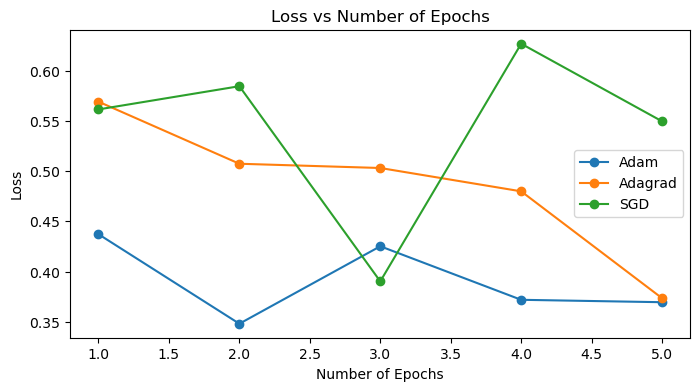

In [97]:
import matplotlib.pyplot as plt

# Extract loss values for each optimizer
adam_loss = results['Adam']['loss']
adagrad_loss = results['Adagrad']['loss']
sgd_loss = results['SGD']['loss']

# Number of epochs
epochs = list(range(1, len(adam_loss) + 1))

# Plotting the lines with reduced figure size
plt.figure(figsize=(8, 4))
plt.plot(epochs, adam_loss, label='Adam', marker='o')
plt.plot(epochs, adagrad_loss, label='Adagrad', marker='o')
plt.plot(epochs, sgd_loss, label='SGD', marker='o')

# Adding labels and title
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Number of Epochs')
plt.legend()

# Display the plot
plt.show()